In [1]:
%load_ext autoreload
%autoreload 2

# Centerline Refinement and Data Loading Example

This section shows an example of how, given an initial guess for the Centerline, that centerline can be further refined to match the data locations using the IteratedRiverObs class. It also shows how, once the Centerline is refined, measurements can be associated with it.

This example illustrates using the output of the SWOT L2 data (i.e., water file) without any supplementary classification information, so that the true water classification, rather than the estimated water classification is used.

In [2]:
import numpy as np
from SWOTRiver import SWOTL2
from RiverObs import ReachExtractor
from RiverObs import RiverObs
from RiverObs import FitRiver
from RiverObs import WidthDataBase
from RiverObs import IteratedRiverObs

/Users/erodrigu/anaconda/envs/RiverObs/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The following imports are for notebook plotting:

In [3]:
%pylab inline
rcParams['font.size'] = 14

# This is optional, but it allows zooming and panning of figures
# Uncomment the block below if you want this feature

#try:
#    import mpld3
#    mpld3.enable_notebook()
#    print 'Interactive plotting enabled'
#except:
#    pass

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
from os.path import exists, join
def find_riverobs_test_data_dir():
    """Fin the location of the test data root directory"""
    
    if 'RIVEROBS_TESTDATA_DIR' in os.environ:
        test_data_dir = os.environ('RIVEROBS_TESTDATA_DIR')
    else: # try the default location
        test_data_dir = '../../../RiverObsTestData'
        
    if not exists(test_data_dir):
        print('You must either set the environment variable RIVEROBS_TESTDATA_DIR')
        print('or locate the test data directory at ../../../RiverObsTestData')
        raise Exception('Test data directory not found.')
        
    return test_data_dir

data_dir = find_riverobs_test_data_dir()
data_dir

'../../../RiverObsTestData'

In [5]:
# This is the file for the width data base

db_dir = join(data_dir,'GRWDL')
width_db_file = join(db_dir,'nAmerica_GRWDL.h5')

# This is the SWOT data

l2_file = join(data_dir,'L2','L2v0','simulated_sacramento_swot_test_data_v0.nc')
assert exists(l2_file)

# This is the file for the reach data base

shape_file_root = join(db_dir,'nAmerica_GRWDL_river_topo','nAmerica_GRWDL_river_topo')

For this example, only data with classification=1 labels are used (pure water pixels) and the latitude and longitude are assumed to be known from the reference interferogram.

In [6]:
class_list=[1]
lat_kwd='no_layover_latitude'
lon_kwd='no_layover_longitude'

l2 = SWOTL2(l2_file,class_list=class_list,lat_kwd=lat_kwd,lon_kwd=lon_kwd)

Cant Find range_index, or azimuth_index variables, assuming 2D-image image coordinates (like from a gdem)


The heights to be used are the noisy height and the water_height, the true height weighted by the radar response.

In [7]:
h = l2.get('height')
htrue = l2.get('water_height')

# Extract the river reaches overlapping the data bounding box

In this case, the reaches are from the North America Global River Width Database for Large Rivers. The data were made by [Tamlin Pavelsky](mailto:pavelsky@unc.edu) and [George Allen](mailto:georgehenryallen@gmail.com) and modified by [Ernesto Rodriguez](mailto:ernesto.rodriguez@jpl.nasa.gov) so that reaches appeared as topologically connected. The results are in the shapefile *nAmerica_GRWDL_river_topo.shp*.

The next step scans through the database and finds all of the overlapping reaches in the data base (only one is found). A small buffer of about 2km is placed about the data bounding box to make sure the river is not cut.

In [8]:
clip_buffer = 0.02
reaches = ReachExtractor(shape_file_root, l2,clip_buffer=clip_buffer)

The following step prints out the reach index and metadata:

In [9]:
print('Reach indexes:',reaches.reach_idx)
print('Metadata:')
reaches[0].metadata

Reach indexes: [704]
Metadata:


{'break_idx': 1388940,
 'latmax': 40.03200149536133,
 'latmin': 38.16350173950195,
 'lonmax': -121.5009994506836,
 'lonmin': -122.11900329589844,
 'npoints': 10144,
 'reach': 375745.03125,
 'reach_idx': 704,
 'width_max': 532.0,
 'width_mean': 115.74655151367188,
 'width_min': 30.0,
 'width_std': 52.802425384521484}

# Extract the width information for this reach from the width database

In [10]:
width_db = WidthDataBase(width_db_file)

max_width = width_db.get_river(reaches.reach_idx[0],
                                      columns=['width'],
                             asarray=True,transpose=False,
                             bounding_box=l2.bounding_box,
                             clip_buffer=clip_buffer)

In [11]:
print('max_width length:',len(max_width))
print('x length:',len(reaches[0].x))

max_width length: 1915
x length: 1915


# Look at where the centerline lies with respect to the data

From this figure, it is clear that the centerline and the SRTM water mask align well in many places, but can have disagreements that are significant compared to the width.

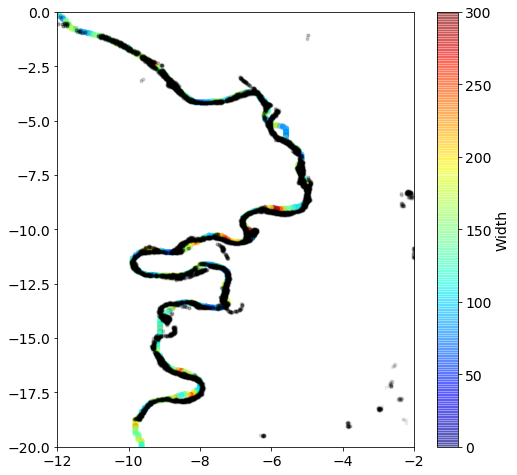

In [12]:
figsize(8,8)
plot(l2.x/1.e3,l2.y/1.e3,'k.',alpha=0.05)
scatter(reaches[0].x/1.e3,reaches[0].y/1.e3,
        c=max_width,
        edgecolor='none',alpha=0.4,
        vmin=0,vmax=300,cmap='jet')
xlim(-12,-2)
ylim(-20,0)
colorbar(label='Width');

**Caption**: In the observations above, the measurement locations are black pixels, while the centerline is in color, width the color representing the estimated width. Notice that the river meanders significantly (i.e., by more than the estimated width) away from the centerline. Notice also that the estimated width does not seem to agree well with the data point distribution.

# Refining the centerline and associating a width to it

Use IteratedRiverObs to refine the centerline and resample the width to the new centerline. Note that the parameter `scalar_max_with` is set large, since a significant number of points are far away from the guessed centerline.

In [13]:
# First step, initialize observations

scalar_max_width = 600.

ds = 50.
minobs = 10
river_obs = IteratedRiverObs(reaches[0],l2.x,l2.y,
                         ds=ds,max_width=scalar_max_width,minobs=minobs) 

num nodes in reach 761


Plot the distribution of distances to the input centerline:

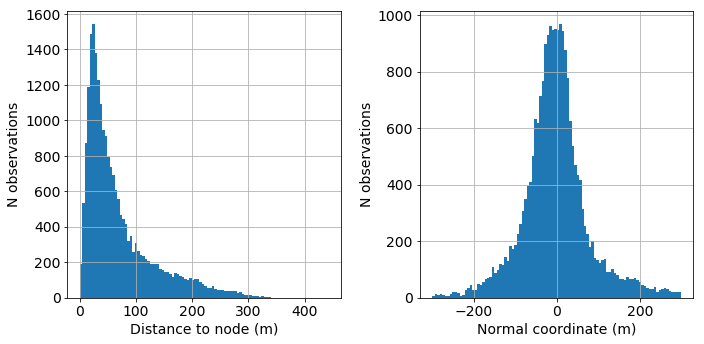

In [14]:
figsize(10,5)
subplot(1,2,1)
hist(river_obs.d,bins=100,log=False)
xlabel('Distance to node (m)')
ylabel('N observations')
grid();
subplot(1,2,2)
hist(river_obs.n,bins=100,log=False)
xlabel('Normal coordinate (m)')
ylabel('N observations')
grid()
tight_layout();

**Caption**: Notice that the distribution is skewed and contains points that outside the nominal river width.

The following step, refines the centerline, but a max_width vector is not yet associated with it.

In [15]:
weights = True
smooth = 1.e-2
river_obs.iterate(weights=weights,smooth=smooth)

iteration 0 maximum coordinate change: 279.979602


Now look at the new centerline (no widths associated).

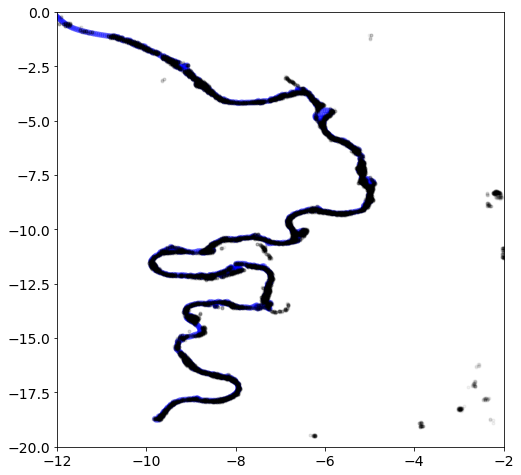

In [16]:
# retrieve the centerline coordinates

xc, yc = river_obs.get_centerline_xy()

figsize(8,8)
plot(l2.x/1.e3,l2.y/1.e3,'k.',alpha=0.05)
scatter(xc/1.e3,yc/1.e3,c='b',
        #c=max_width,
        edgecolor='none',alpha=0.4)#,
        #vmin=0,vmax=300)
xlim(-12,-2)
ylim(-20,0);

Now look at the new distribution of points relative to the new centerline:

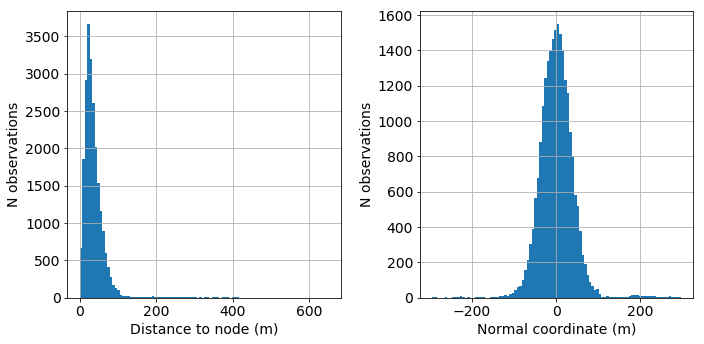

In [17]:
figsize(10,5)
subplot(1,2,1)
hist(river_obs.d,bins=100,log=False)
xlabel('Distance to node (m)')
ylabel('N observations')
grid();
subplot(1,2,2)
hist(river_obs.n,bins=100,log=False)
xlabel('Normal coordinate (m)')
ylabel('N observations')
grid()
tight_layout();

**Caption**: Much nicer! The points are close to the new river centerline.

In the next step, associate the estimated widths with the new centerline. Notice that this can only be done approximately, since there is no unique one to one mapping.

In [18]:
# These are the old centerline coordinates

xw = reaches[0].x
yw = reaches[0].y

# This step makes the association

river_obs.add_centerline_obs(xw,yw,max_width,'max_width')

Now get the centerline coordinates that could be associated with a max_width and the associated max_width and plot the results.

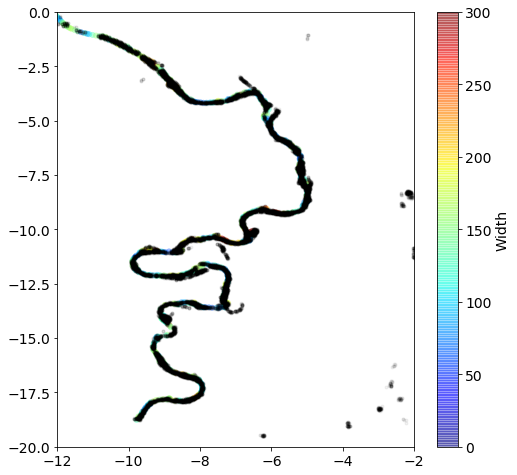

In [19]:
xi, yi, wi = river_obs.get_centerline_xyv('max_width')

figsize(8,8)
plot(l2.x/1.e3,l2.y/1.e3,'k.',alpha=0.05)
scatter(xi/1.e3,yi/1.e3,
        c=wi,
        edgecolor='none',alpha=0.4,
        vmin=0,vmax=300,cmap='jet')
xlim(-12,-2)
ylim(-20,0);
colorbar(label='Width');

**Caption**: Not too bad, but notice the widths do not always match the data distribution.

# Compute the center line and associate observations with it

In the following step, the new centerline and max_width vector are used to exclude the bad data.

In [20]:
river_obs.reinitialize()

num nodes in reach 802


Plot the maximum width along the channel:

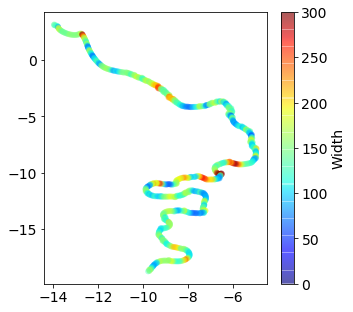

In [21]:
figsize(5,5)
scatter(river_obs.centerline.x/1.e3,river_obs.centerline.y/1.e3,
        c=river_obs.max_width,
        edgecolor='none',alpha=0.4,
        vmin=0,vmax=300,cmap='jet')
colorbar(label='Width');

In the following step, the height and true heights are associated with the nodes:

In [22]:
river_obs.add_obs('htrue',htrue)
river_obs.add_obs('h',h)
river_obs.load_nodes(['h','htrue'])

Get some rough statistics of the differences in heights for the data associated with each node:

In [23]:
hn_mean = np.array(river_obs.get_node_stat('mean','h'))
hn_median = np.array(river_obs.get_node_stat('median','h'))
hstdn = np.array(river_obs.get_node_stat('stderr','h'))
htn = np.array(river_obs.get_node_stat('mean','htrue'))
sn = np.array(river_obs.get_node_stat('mean','s'))

In [24]:
ave = np.mean(hn_mean - htn)*100
err = np.std(hn_mean - htn)*100
print('Mean statitics:   average: %.1f cm std: %.1f cm'%(ave,err))

ave = np.mean(hn_median - htn)*100
err = np.std(hn_median - htn)*100
print('Median statitics: average: %.1f cm std: %.1f cm'%(ave,err))

Mean statitics:   average: 4.2 cm std: 69.9 cm
Median statitics: average: 6.4 cm std: 71.0 cm


Plot the distances from the points to the nodes, and the cross-river normal coordinate:

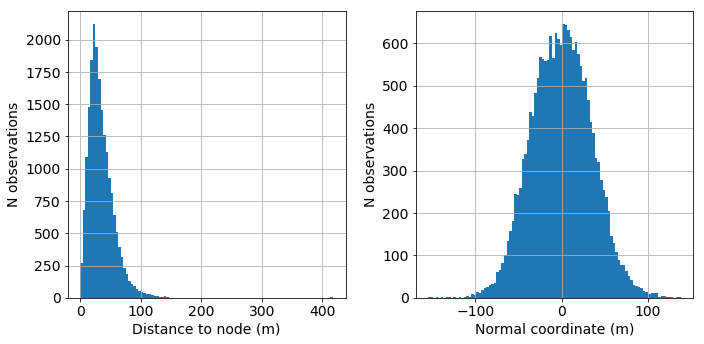

In [25]:
figsize(10,5)
subplot(1,2,1)
hist(river_obs.d,bins=100,log=False)
xlabel('Distance to node (m)')
ylabel('N observations')
grid();
subplot(1,2,2)
hist(river_obs.n,bins=100,log=False)
xlabel('Normal coordinate (m)')
ylabel('N observations')
grid()
tight_layout();

Plot the river geometry, number of observations per node, height vs true height, and a plot of height vs the reach distance downriver.

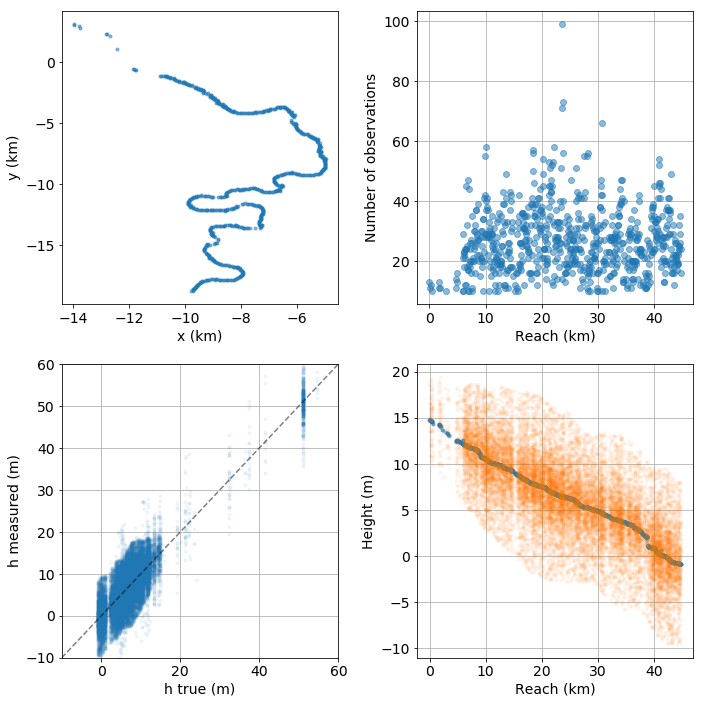

In [26]:
figsize(10,10)
subplot(2,2,1)
idx = river_obs.populated_nodes
plot(river_obs.centerline.x[idx]/1.e3,river_obs.centerline.y[idx]/1.e3,
     '.',alpha=0.5)
xlabel('x (km)')
ylabel('y (km)')
subplot(2,2,2)
idx = river_obs.populated_nodes
plot(river_obs.centerline.s[idx]/1.e3,river_obs.nobs[idx],'o',alpha=0.5)
grid()
xlabel('Reach (km)')
ylabel('Number of observations')
subplot(2,2,3)
plot(htrue,h,'.',alpha=0.05)
plot([-10,60],[-10,60],'--k',alpha=0.5)
xlim(-10,60)
ylim(-10,60)
grid()
xlabel('h true (m)')
ylabel('h measured (m)')
subplot(2,2,4)
plot(river_obs.s/1.e3,river_obs.htrue,'.',alpha=0.1)
plot(river_obs.s/1.e3,river_obs.h,'.',alpha=0.05)
grid()
xlabel('Reach (km)')
ylabel('Height (m)')
tight_layout();

Plot the true river height averaged over each node, and the measured height, similarly averaged for mean and median averaging. The gray lines are 2 standard errors away from the truth.

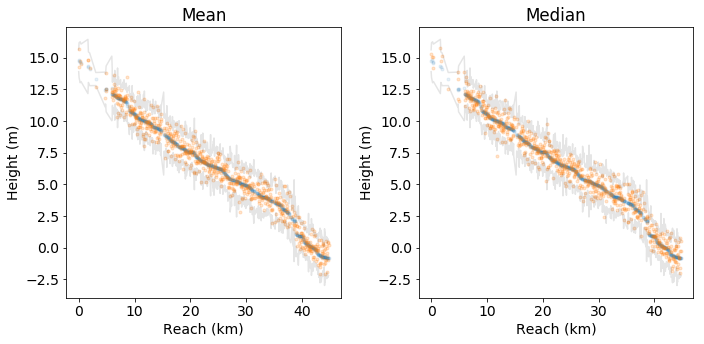

In [27]:
figsize(10,5)
subplot(1,2,1)
plot(sn/1.e3,htn,'.',alpha=0.1)
plot(sn/1.e3,hn_mean,'.',alpha=0.2)
plot(sn/1.e3,htn+2*hstdn,'-k',alpha=0.1)
plot(sn/1.e3,htn-2*hstdn,'-k',alpha=0.1)
xlabel('Reach (km)')
ylabel('Height (m)')
title('Mean')

subplot(1,2,2)
plot(sn/1.e3,htn,'.',alpha=0.1)
plot(sn/1.e3,hn_median,'.',alpha=0.2)
plot(sn/1.e3,htn+2*hstdn,'-k',alpha=0.1)
plot(sn/1.e3,htn-2*hstdn,'-k',alpha=0.1)
xlabel('Reach (km)')
title('Median')
ylabel('Height (m)')
tight_layout();